In [6]:
import h5py
import sys
import numpy as np
from scipy import io
from scipy.signal import hilbert as hilbert
from math import *;

import re
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import argparse

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
import stringmisc

def grnumaxis(nslc):
    sqr=np.sqrt(nslc)
    if np.abs(np.mod( sqr, 1.0))<1e-16:
        #is perfect square
        nnc=int(sqr)
    else:
        nnc=floor(sqr)+1
    
    nnr = ceil(nslc/nnc)

    return (nnr,nnc)
def grax_ij(slidx, nnr,nnc):
    j_ax = np.mod(slidx,nnc)
    i_ax = floor(slidx/nnc)
    return (i_ax,j_ax)

In [7]:
def abshilbert(x):
    return np.abs(hilbert(x))

In [8]:
def oneLogisticNotchFiltFunc(fx,f_lo,f_hi,scale):
    return 1.0 / (1 + np.exp(scale*(fx-f_lo)) ) + 1.0 / (1 + np.exp(-scale*(fx-f_hi)) )
    
def LogisticNotchFilter(fx,f0,window,nharm,harmstep=1.0, scale=200.0):
    """
    Recursive construction of filter.
    Actual filter is [fn + window[0], fn + window[1]] around each step
    """

    fn = f0*nharm
    f_lo = fn+window[0]
    f_hi = fn+window[1]
    F = oneLogisticNotchFiltFunc(fx,f_lo, f_hi, scale)        
        
    if (nharm-harmstep)<=1e-9:
        #lowest recursion depth (fundamental or lowest subharmonic):
        return F
    else:    
        Fb = LogisticNotchFilter(fx, f0, window, nharm-harmstep, harmstep=harmstep, scale=scale)
    
    return Fb*F
    
def getParamFile(file):
    """
    """
    datapath = os.path.dirname(file)
    (dataname,ext) = os.path.basename(file).split(".")

    return (os.path.join(datapath , dataname +"_params.mat"),ext)

def load_cavitation_params(params_file):
    """
    """
    pardict=io.loadmat(params_file,squeeze_me=True,struct_as_record=False)
    params = pardict['params']
    
    return params
    
def load_veradata_2x128_bin(datafile,params=None):
    """
    Load a 256-recieve channel data set, formed from two 128-channel probes.
    Output rf_data is split into two 128-channel arrays of shape (numsamples, 128, numframes)
    
    (rf1, rf2) = load_veradata_2x128_bin(file)    
    
    """
    if params is None:
        params = load_cavitation_params(params_file)
    
    ns=params.numRcvSamples
    Nchan = params.numRcvChannels
    
    if Nchan!=256:
        raise ValueError("Expected 256-channel data (params file "+params_file+")")
    
    bmodes = params.num_final_bmode_acs
    
    rf_data = np.zeros([ns, Nchan, params.numframes*params.numacq],dtype=np.int16)     
    
    bmodeStartidx = ns*Nchan*params.numframes*params.numacq
    
    with open(datafile, 'rb') as fid:
        chandat = np.fromfile(fid, np.int16)
        if bmodes>0:
            bmodedat = np.zeros([ns,256,bmodes],dtype=np.int16)
            bchandat = chandat[bmodeStartidx:].reshape([1,256,bmodes,ns])
            for bi in range(bmodes):
                print(bi)
                bmodedat[:,:,bi]=bchandat[0,:,bi,:].transpose()
                            
            bmodedat=np.array_split(bmodedat,2,axis=1)
        else:
            bmodedat=None
            
        chandat = chandat[0:bmodeStartidx].reshape([params.numframes,Nchan,params.numacq,ns])
        
    for f in range(0, params.numframes):
        for a in range(0, params.numacq):
            #rf_data[:,:,f*params.numacq + a] = chandat[:,a,:,f]
            rf_data[:,:,f*params.numacq + a] = chandat[f,:,a,:].transpose()
   
    (probe1, probe2) = np.array_split(rf_data,2,axis=1)
    
    return (probe1, probe2, bmodedat)

In [47]:
datafile="/Users/Vandiver/Data/Verasonics/sonalleve_20160824/pork/single/single_80W.bin"
datafile="/Users/Vandiver/Data/Verasonics/sonalleve_20160824/fiducial/posXA.bin"
#datafile="/Users/Vandiver/Data/Verasonics/sonalleve_20160803/chicken/multi_2/multi_2_60W.bin"
#datafile2="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/multi_1/multi_1_80W.bin"
#datafile="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/multi_2/multi_2_60W.bin"

datafile_basename=os.path.basename(datafile)
print('')
print('Processing: %s'% datafile_basename)    

path=os.path.dirname(os.path.abspath(datafile))
params_file,ext = getParamFile(datafile)

params = load_cavitation_params(params_file)
#params2= load_cavitation_params(getParamFile(datafile2)[0])

#if binary file
(rf_probe1,rf_probe2, BmodeData) = load_veradata_2x128_bin(datafile, params=params)
(ns,Nchan,totframes)=rf_probe1.shape  

#(rf_probe1_2,rf_probe2_2, BmodeData2) = load_veradata_2x128_bin(datafile2, params=params2)

numf = params.numframes
numa = params.numacq


Processing: posXA.bin
0
1


In [60]:
rf_probe1.shape

(3072, 128, 100)

In [62]:
(3072/params.fs)*1480

0.21824884792626728

In [63]:
Fs = 4*Trans['frequency']*1e6;
dt = 1/Fs;

In [64]:
dt

4.8003072196620586e-08

In [66]:
rf_probe1.shape[0]*dt

0.00014746543778801845

In [11]:
c=1540; 
Trans={}
Trans['spacing']=params.pitch;
Trans['frequency']=params.fs/4*1e-6;
#wavelength = c/(Trans['frequency']*1e6);

Fs = 4*Trans['frequency']*1e6;
dt = 1/Fs;

dx = 2e-4
dz = 2e-4

ducer_width = params.pitch*Nchan

Nx = round(ducer_width/dx)
#Nz = round(ns/2*c*dt/dz);
#Nz = round(9e-2/dz)

xpnts = np.linspace(-0.5,0.5,Nx)*Nx*dx
#zpnts = np.linspace(0,1,Nz)*Nz*dz
#xpnts = np.arange(-1e-2,0.5e-2,dx)
#Nx=len(xpnts)
zpnts = np.arange(4.0e-2,9e-2,dz)
Nz=len(zpnts)

#sensor positions
ux1 = (np.linspace(-0.5,0.5,Nchan)*Nchan + 0.5)*params.pitch     
uz1 = np.zeros(Nchan)

#registration manually determined from summed images 
#flip left-right

#07/09
ux2 = ux1[-1::-1] - 5*dx
uz2 = 13e-2+30*dz #constant offset

#08/03
#ux2 = ux1[-1::-1] - 0.45e-2
#uz2 = 13.6e-2 + 0.0135e-2

#08/24
#ux2 = ux1[-1::-1] + 1e-2
#uz2 = 13.6e-2

ux2=ux1
uz2=uz1

do_fft_filt=False



In [65]:
5*dx

0.001

In [13]:
Nx*Nz

13125

In [89]:
7.59+6.05

13.64

In [90]:
6.97+6.6

13.57

In [12]:
#image and resampling grids
ndZ1,ndX1,ndux1 = np.meshgrid(zpnts,xpnts,ux1, indexing='ij')
ndZ2,ndX2,ndux2 = np.meshgrid(zpnts,xpnts,ux2, indexing='ij')


distances1 = np.sqrt( (ndX1-ndux1)**2 + ndZ1**2 )
delayinds1 = np.round( distances1 / (c*dt)).astype(int)
inbounds1 = (delayinds1 < ns)
ii1=np.nonzero(inbounds1)

distances2 = np.sqrt( (ndX2-ndux2)**2 + (ndZ2-uz2)**2 )
delayinds2 = np.round( distances2 / (c*dt)).astype(int)
inbounds2 = (delayinds2 < ns)
ii2=np.nonzero(inbounds2)

fnum=0
ape1 = np.abs(ndZ1 / (2*(ndX1-ndux1)))>=fnum
ape2 = np.abs((ndZ2-uz2) / (2*(ndX2-ndux2)))>=fnum


del ndZ1,ndX1,ndux1,ndZ2,ndX2,ndux2

delaySets = [(distances1,delayinds1, inbounds1, ii1,ape1), (distances2,delayinds2, inbounds2, ii2,ape2)]


In [136]:
delayed=np.zeros([Nz,Nx,Nchan])

superFrames = np.arange(0,numf,dtype=int)
#superFrames = np.arange(27,27+numf)

acqs = np.arange(0,numa,dtype=int)

superFrames=[0]
acqs=list(range(1,10))

numSF = len(superFrames)

Moment1Imgf = np.zeros([2,numSF,Nz,Nx])
Moment2Imgf = np.zeros([2,numSF,Nz,Nx])
ProbeCrossTerm = np.ones([numSF,params.numacq,Nz,Nx])
rmsPerImage = np.zeros([numSF,params.numacq])
bbNoisePerAcq = np.zeros([numSF*params.numacq])

probenum=0
for rf_data in (rf_probe1, rf_probe2):
    
    delayed*=0
    (distances, delayinds, inbounds3, ii,ape) = delaySets[probenum]
    
    for sfi in range(0,numSF):
        sf = superFrames[sfi]
        
        for a in acqs:
            delayed[:]=0
            
            if do_fft_filt:
                rf_fft = np.fft.fft( rf_data[:,:,sf*params.numacq + a],NFFT,axis=0)

                #efficiently multiply the filter along the first dimension
                filtFFT = rf_fft*harmonicFilter[:,np.newaxis]
                chSumSpec = np.sum(np.abs(2*rf_fft[0:endidx]),axis=1)
                bbNoiseLevel = np.sum( 2*np.abs(filtFFT[0:endidx])) 

                delayed[ii[0],ii[1],ii[2]] = np.real ( np.fft.ifft(filtFFT,n=NFFT,axis=0) )[delayinds[inbounds3],ii[2]]

                bbNoisePerAcq[sfi*params.numacq + a]=bbNoiseLevel
                spectrumPerFrame[sfi] += chSumSpec               
            else:

                delayed[ii[0],ii[1],ii[2]] = rf_data[delayinds[inbounds3],ii[2],sf*params.numacq + a]
            
            chandelaysum = np.sum(ape*distances*delayed,axis=2)
            chandelaysum2 = np.sum( (ape*distances*delayed)**2,axis=2)
            #summed_passivemap = chandelaysum**2

            #rmsPerImage[sfi,a] = np.sum(summed_passivemap,axis=(0,1))
            
            ProbeCrossTerm[sfi,a]*=chandelaysum
            Moment1Imgf[probenum,sfi]+=chandelaysum**2
            Moment2Imgf[probenum,sfi]+=chandelaysum2

            print("\r%d/%d"%(sf*params.numacq + a, superFrames[-1]*params.numacq + acqs[-1]),end='', flush=True)
            
        Moment1Imgf[probenum,sfi]/=len(acqs)        
        Moment2Imgf[probenum,sfi]/=len(acqs)
    probenum+=1

9/9

In [137]:
numimages=numSF
varianceImage1 = np.sum(Moment1Imgf[0]**2,axis=0)/numimages - np.sum(Moment2Imgf[0],axis=0)/numimages
varianceImage2 = np.sum(Moment1Imgf[1]**2,axis=0)/numimages - np.sum(Moment2Imgf[1],axis=0)/numimages

summedImage = varianceImage1+varianceImage2
coupledImage = summedImage + (2*np.mean(ProbeCrossTerm,axis=(0,1)))


extent=np.array([xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]])*100

In [135]:
np.max(2*np.mean(ProbeCrossTerm,axis=(0,1)))

27921.950556455733

In [18]:
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow((2*np.mean(ProbeCrossTerm,axis=(0,1))))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.abs(2*np.mean(ProbeCrossTerm,axis=(0,1))))
plt.colorbar()

In [11]:
%matplotlib qt4

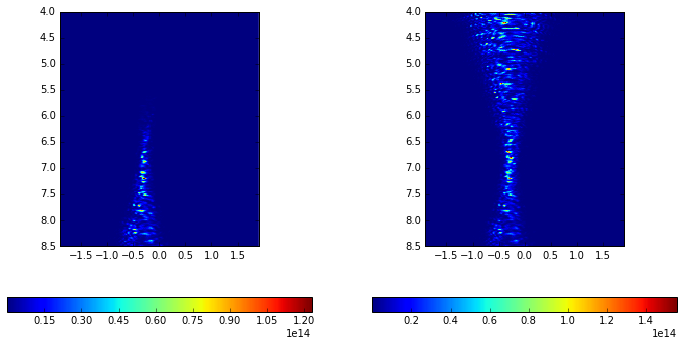

In [138]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(varianceImage1,interpolation='none',extent=extent)
plt.colorbar(orientation='horizontal')
plt.subplot(122)
plt.imshow(varianceImage2+varianceImage1,interpolation='none',extent=extent)
plt.colorbar(orientation='horizontal')

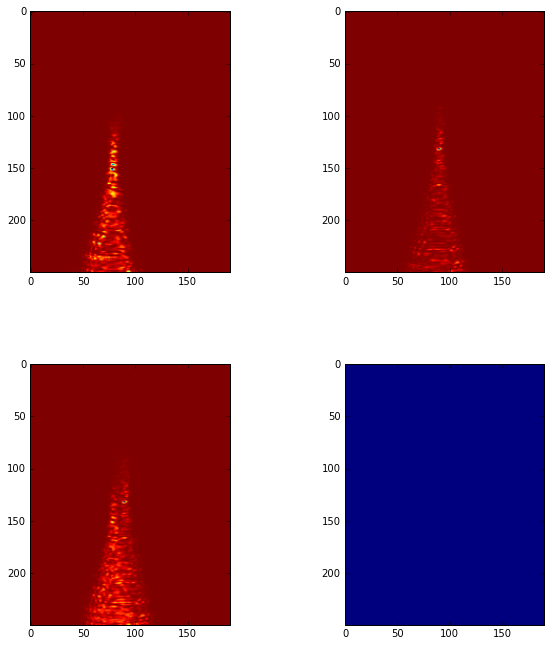

In [18]:
gs=gridspec.GridSpec(2,2,wspace=0.05,hspace=0.35)

fig=plt.figure(figsize=(11,11))

for probe in range(2):
    ax=fig.add_subplot(gs[0,probe])
    ax.imshow( np.mean(Moment2Imgf[probe],axis=0) - np.mean(Moment1Imgf[probe],axis=0)**2 )

for j in range(2):
    ax=fig.add_subplot(gs[1,j])
    if j==0:
        ax.imshow( np.mean(np.sum(Moment2Imgf,axis=0),axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 )
    else:
        ax.imshow( np.mean(np.sum(Moment1Imgf,axis=0)**2,axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 )

In [164]:
mu1=np.mean(np.sum(Moment2Imgf,axis=0),axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 
mu2=np.mean(np.sum(Moment1Imgf,axis=0)**2,axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2

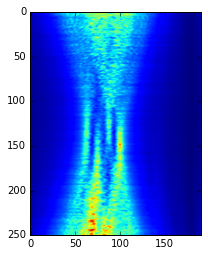

In [165]:
plt.imshow((1+np.abs(hilbert(mu1))))

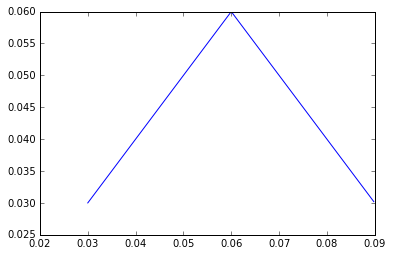

In [261]:
rr=zpnts.copy()
ob=rr>0.06
rr[ob]=-rr[ob]+2*0.06
plt.plot(zpnts, rr)

### CCF

In [13]:
#image and resampling grids
ndZ1,ndX1,ndux1 = np.meshgrid(zpnts,xpnts,ux1, indexing='ij')

distances1 = np.sqrt( (ndX1-ndux1)**2 + ndZ1**2 )
delayinds1 = np.round( distances1 / (c*dt)).astype(int)
inbounds1 = (delayinds1 < ns)
ii1=np.nonzero(inbounds1)

fnum=0
ape1 = np.abs(ndZ1 / (2*(ndX1-ndux1)))>=fnum

probeDelays = [(distances1,delayinds1, inbounds1, ii1,ape1), ()]

del ndZ1,ndX1,ndux1

def getProbe2DelaySet(uz2,ux2, yplane=0.0,trips=1,fnum=0):
    ndZ2,ndX2,ndux2 = np.meshgrid(zpnts,xpnts,ux2, indexing='ij')
    distances2 = trips*np.sqrt( (ndX2-ndux2)**2 + yplane**2 + (ndZ2-uz2)**2 )
    delayinds2 = np.round( distances2 / (c*dt)).astype(int)
    inbounds2 = (delayinds2 < ns)
    ii2=np.nonzero(inbounds2)
    ape2 = np.abs((ndZ2-uz2) / (2*(ndX2-ndux2)))>=fnum
    
    #ob=distances2>0.06
    #distances2[ob]=-distances2[ob]+2*0.06
    
    return  (distances2,delayinds2, inbounds2, ii2,ape2)

def probe_ccf(delaySets,frames=[0],acqs=[1],do_fft_filt=False,rfSets=(rf_probe1, rf_probe2)):
    probenum=0
    numSF=len(frames)
    
    ProbeCrossCorr = np.ones([numSF,len(acqs),Nz,Nx])
    
    mom2 = np.zeros([Nz,Nx])
    mom1 = np.zeros([Nz,Nx])
    for rf_data in rfSets:

        #delayed*=0
        (distances, delayinds, inbounds3, ii,ape) = delaySets[probenum]
        
        delayed = np.zeros_like(distances)

        for sfi in range(0,numSF):
            sf = frames[sfi]

            for ai in range(len(acqs)):
                a=acqs[ai]
                delayed[:]=0

                if do_fft_filt:
                    rf_fft = np.fft.fft( rf_data[:,:,sf*params.numacq + a],NFFT,axis=0)

                    #efficiently multiply the filter along the first dimension
                    filtFFT = rf_fft*harmonicFilter[:,np.newaxis]
                    chSumSpec = np.sum(np.abs(2*rf_fft[0:endidx]),axis=1)
                    bbNoiseLevel = np.sum( 2*np.abs(filtFFT[0:endidx])) 

                    delayed[ii[0],ii[1],ii[2]] = np.real ( np.fft.ifft(filtFFT,n=NFFT,axis=0) )[delayinds[inbounds3],ii[2]]

                    bbNoisePerAcq[sfi*params.numacq + a]=bbNoiseLevel
                    spectrumPerFrame[sfi] += chSumSpec               
                else:

                    delayed[ii[0],ii[1],ii[2]] = rf_data[delayinds[inbounds3],ii[2],sf*params.numacq + a]

                beamformed=ape*distances*delayed
                chandelaysum = np.sum(beamformed,axis=2)
                chandelaysum2 = np.sum( (beamformed)**2,axis=2)

                ProbeCrossCorr[sfi,ai]*=chandelaysum

                mom1+=chandelaysum**2
                mom2+=chandelaysum2


                print("\r%d/%d"%(sf*params.numacq + a, frames[-1]*params.numacq + acqs[-1]),end='', flush=True)

        probenum+=1
    
    avgCorr = np.mean(ProbeCrossCorr,axis=(0,1))

    return (avgCorr, mom1, mom2)


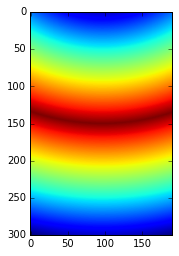

In [275]:
plt.imshow( probeDelays[1][0][:,:,64])

In [14]:
ux2 = ux1
uz2 = 0

In [31]:
ux2 = ux1[-1::-1] - 0.35e-2
uz2 = 12.6e-2

In [17]:
MapRenormValue=1e7
extent=100*np.array([xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]])

In [48]:
probeDelays[0] = getProbe2DelaySet(uz1,ux1)
probeDelays[1] = getProbe2DelaySet(uz2,ux2)

bmodeDelays = [getProbe2DelaySet(uz1,ux1,trips=2,fnum=2), getProbe2DelaySet(uz2,ux2,trips=2,fnum=2)]

In [202]:
rf_probe1.shape

(3072, 128, 600)

In [49]:
probe1pcmap=probe_ccf([probeDelays[0]],acqs=range(1,21),frames=[0,1],rfSets=[rf_probe1])
probe2pcmap=probe_ccf([probeDelays[1]],acqs=range(1,21),frames=[0,1],rfSets=[rf_probe2])

40/40

In [38]:
probe0pcmap=probe_ccf(probeDelays,acqs=range(1,21),frames=[0,1],rfSets=[rf_probe1,rf_probe2])

40/40

In [34]:
%matplotlib inline

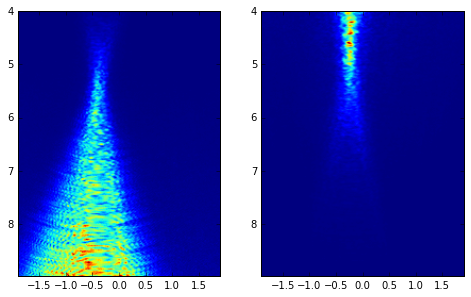

In [51]:
fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.imshow( probe1pcmap[1]+0*probe2pcmap[1],extent=extent )
ax2.imshow( probe2pcmap[1],extent=extent )

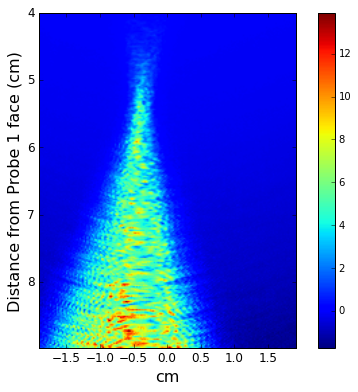

In [56]:
fig=plt.figure(figsize=(8,6))
plt.imshow( (probe1pcmap[1] -probe1pcmap[2] + probe1pcmap[0])/MapRenormValue,extent=extent)
plt.colorbar()

plt.ylabel('Distance from Probe 1 face (cm)',fontsize=16)
plt.xlabel('cm',fontsize=16)
plt.gca().tick_params(labelsize=12)

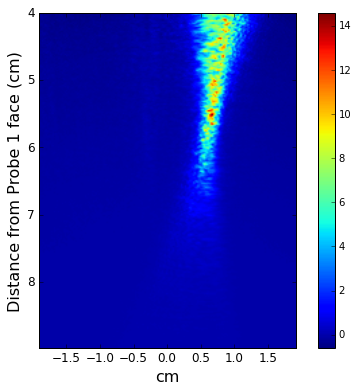

In [44]:
fig=plt.figure(figsize=(8,6))
plt.imshow((probe2pcmap[1] -probe2pcmap[2] + probe2pcmap[0])/MapRenormValue,extent=extent)
plt.colorbar()
plt.ylabel('Distance from Probe 1 face (cm)',fontsize=16)
plt.xlabel('cm',fontsize=16)
plt.gca().tick_params(labelsize=12)

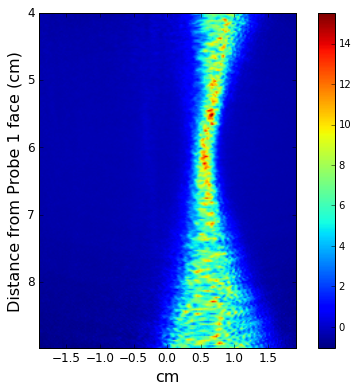

In [41]:
fig=plt.figure(figsize=(8,6))
plt.imshow((probe0pcmap[1] -probe0pcmap[2] + probe0pcmap[0])/MapRenormValue,extent=extent)
plt.colorbar()
plt.ylabel('Distance from Probe 1 face (cm)',fontsize=16)
plt.xlabel('cm',fontsize=16)
plt.gca().tick_params(labelsize=12)

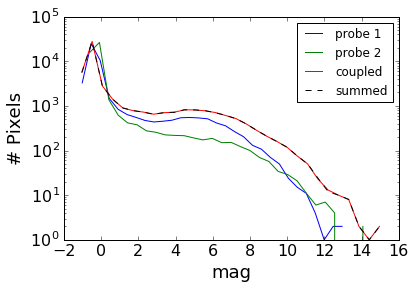

In [42]:
im1=(probe1pcmap[1] -probe1pcmap[2] + probe1pcmap[0])/MapRenormValue
im2=(probe2pcmap[1] -probe2pcmap[2] + probe2pcmap[0])/MapRenormValue
im0=(probe0pcmap[1] -probe0pcmap[2] + probe0pcmap[0])/MapRenormValue
(hy1,hx1) = np.histogram(im1,bins=30,normed=False)        
(hy2,hx2) = np.histogram(im2,bins=30,normed=False) 
(hy0,hx0) = np.histogram(im0,bins=30,normed=False) 
(hyS,hxS) = np.histogram((im1+im2),bins=30,normed=False) 

plt.plot(hx1[0:-1],hy1)
plt.plot(hx2[0:-1],hy2)
plt.plot(hx0[0:-1],hy0)
plt.plot(hxS[0:-1],hyS,'k--')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('mag',fontsize=18)
plt.ylabel('# Pixels',fontsize=18)
plt.legend(['probe 1', 'probe 2', 'coupled','summed'],fontsize=12)
plt.gca().tick_params(labelsize=16)

In [203]:
cav=probe_ccf(probeDelays,acqs=range(1,21),frames=[0],rfSets=(rf_probe1,rf_probe2))

20/20

In [183]:
cav2=probe_ccf(probeDelays,acqs=range(1,21),frames=[0,1,2,3],rfSets=(rf_probe1_2,rf_probe2_2))

80/80

In [152]:
bret = probe_ccf(bmodeDelays, acqs=[0,1],rfSets=[BmodeData[0]])

1/1

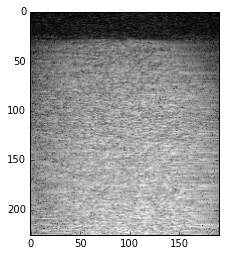

In [153]:
plt.imshow(np.log10(1+abshilbert(bret[1])),cmap=image.cm.gray )

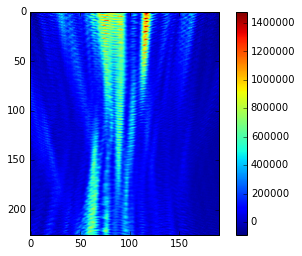

In [204]:
plt.imshow(cav[1] -cav[2] + cav[0])
plt.colorbar()

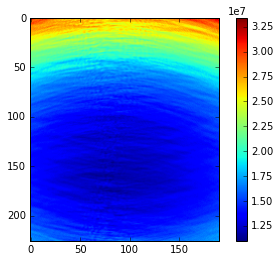

In [189]:
plt.imshow(cav2[2] )
plt.colorbar()

In [127]:
(distances, delayinds, inbounds3, ii,ape) = probeDelays[1]

In [72]:
ccf.shape

(151, 191)

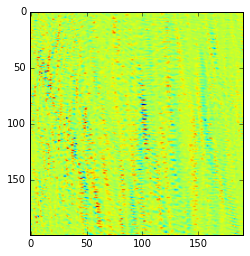

In [93]:
plt.imshow(ccf)

In [10]:
#XOffsets = np.arange(-20, 20,1) *dx - 0.5e-2
XOffsets = np.arange(-14,14.1,2)*1e-3
ZOffsets = np.arange( 12.2e-2 , 14.001e-2, dz )

CCF = np.zeros([len(ZOffsets),len(XOffsets)] )
CCFabs = np.zeros([len(ZOffsets),len(XOffsets)] )

for zi in range(len(ZOffsets)):
    print("zi=%d"%zi,flush=True)
    for xi in range(len(XOffsets)):
        
        ux2 = ux1[-1::-1] + XOffsets[xi]
        uz2 = ZOffsets[zi]
        
        probeDelays[1] = getProbe2DelaySet(uz2,ux2)
        
        ccf,junk,junk=probe_ccf(probeDelays,acqs=range(2,10),frames=[0])
        
        CCF[zi,xi] = np.sum(ccf)
        CCFabs[zi,xi] = np.sum(np.abs(ccf))

zi=0
9/9zi=1
9/9zi=2
9/9zi=3
9/9zi=4
9/9zi=5
9/9zi=6
9/9zi=7
9/9zi=8
9/9zi=9
9/9zi=10
9/9zi=11
9/9zi=12
9/9zi=13
9/9zi=14
9/9zi=15
9/9zi=16
9/9zi=17
9/9zi=18
9/9zi=19
9/9zi=20
9/9zi=21
9/9zi=22
9/9zi=23
9/9zi=24
9/9zi=25
9/9zi=26
9/9zi=27
9/9zi=28
9/9zi=29
9/9zi=30
9/9zi=31
9/9zi=32
9/9zi=33
9/9zi=34
9/9zi=35
9/9zi=36
9/9zi=37
9/9zi=38
9/9zi=39
9/9zi=40
9/9zi=41
9/9zi=42
9/9zi=43
9/9zi=44
9/9zi=45
9/9zi=46
9/9zi=47
9/9zi=48
9/9zi=49
9/9zi=50
9/9zi=51
9/9zi=52
9/9zi=53
9/9zi=54
9/9zi=55
9/9zi=56
9/9zi=57
9/9zi=58
9/9zi=59
9/9zi=60
9/9zi=61
9/9zi=62
9/9zi=63
9/9zi=64
9/9zi=65
9/9zi=66
9/9zi=67
9/9zi=68
9/9zi=69
9/9zi=70
9/9zi=71
9/9zi=72
9/9zi=73
9/9zi=74
9/9zi=75
9/9zi=76
9/9zi=77
9/9zi=78
9/9zi=79
9/9zi=80
9/9zi=81
9/9zi=82
9/9zi=83
9/9zi=84
9/9zi=85
9/9zi=86
9/9zi=87
9/9zi=88
9/9zi=89
9/9zi=90
9/9

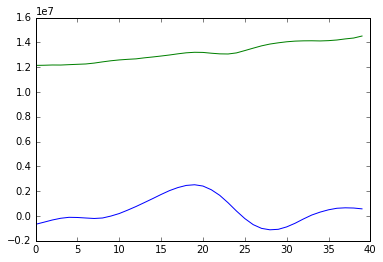

In [98]:
plt.plot( CCF[0,:])
plt.plot( CCFabs[0,:])

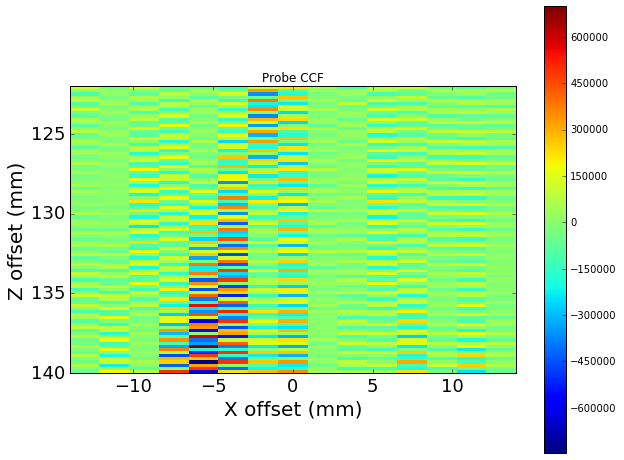

In [15]:
plt.figure(figsize=(10,8))
plt.imshow((CCF), extent=np.array([ XOffsets[0], XOffsets[-1], ZOffsets[-1], ZOffsets[0]])*1e3, interpolation='none')
plt.xlabel('X offset (mm)',fontsize=20)
plt.ylabel('Z offset (mm)',fontsize=20)
plt.title('Probe CCF')
plt.gca().tick_params(labelsize=18)
plt.colorbar()

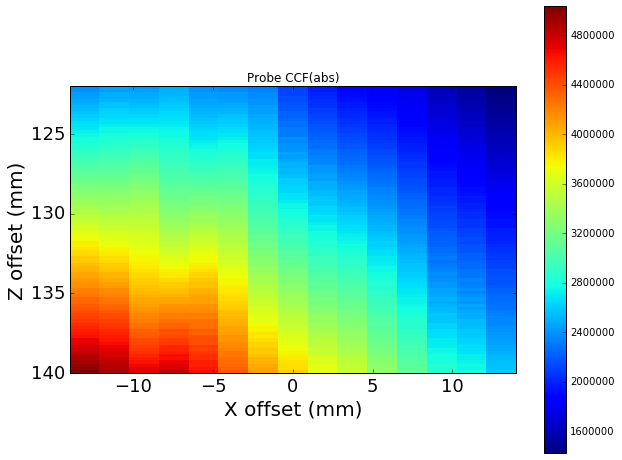

In [14]:
plt.figure(figsize=(10,8))
plt.imshow((CCFabs), extent=np.array([ XOffsets[0], XOffsets[-1], ZOffsets[-1], ZOffsets[0]])*1e3, interpolation='none')
plt.xlabel('X offset (mm)',fontsize=20)
plt.ylabel('Z offset (mm)',fontsize=20)
plt.title('Probe CCF(abs)')
plt.gca().tick_params(labelsize=18)
plt.colorbar()

9/9

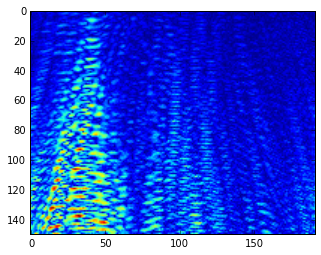

In [86]:
ux2 = ux1[-1::-1] - 13e-3
uz2 = .140

probeDelays[0] = getProbe2DelaySet(uz1,ux1,yplane=-0.0)
#probeDelays[1] = getProbe2DelaySet(uz2,ux2)
#probeDelays[1]=probeDelays[0]
ccf,mom1,mom2=probe_ccf(probeDelays,acqs=range(2,10),frames=[0],rfSets=[rf_probe1])

plt.imshow(abshilbert(np.abs(ccf)))

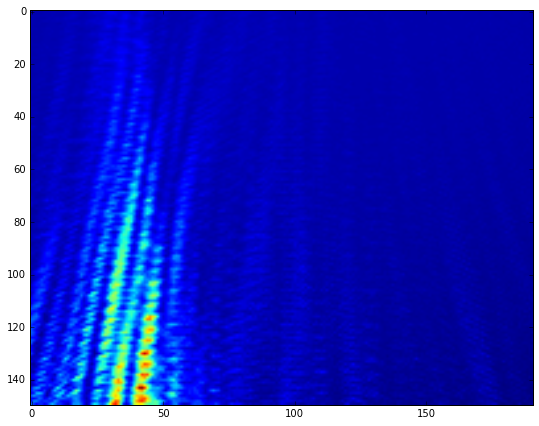

In [87]:
plt.figure(figsize=(9,9))
plt.imshow(mom1 - mom2)

9/9

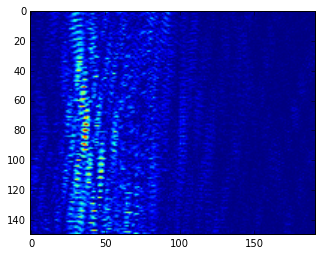

In [46]:
ux2 = ux1[-1::-1] - 6e-3
uz2 = .138

probeDelays[1] = getProbe2DelaySet(uz2,ux2)

ccf2,mom12,mom22=probe_ccf(probeDelays,acqs=range(2,10),frames=[0])

plt.imshow(np.abs(ccf2))

In [ ]:
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

In [89]:
def create_elevational_maps(uzux, probeData,ysteps=np.arange(-0.01,0.01,0.001)):
    probeDel=[(),()]
    
    imgData = np.zeros([len(ysteps),Nz,Nx])
    ccfData= np.zeros([len(ysteps),Nz,Nx])
    for yi in range(len(ysteps)):
        for pn in range(len(uzux)):
            uz = uzux[pn][0]
            ux = uzux[pn][1]
            probeDel[pn] = getProbe2DelaySet(uz,ux,yplane=ysteps[yi])

        ccf,mom1,mom2=probe_ccf(probeDel,acqs=range(2,10),frames=[0],rfSets=probeData)
        imgData[yi] = mom1-mom2
        ccfData[yi] =ccf
        
    return (imgData,ccfData)

In [109]:
ysteps=np.arange(-0.01,0.01,0.001)
ux2 = ux1[-1::-1] - 6e-3
uz2 = .138
(imgDataVsY,ccfDataVsY) =create_elevational_maps( [[uz1,ux1],[uz2,ux2]], [rf_probe1,rf_probe2],ysteps=ysteps)

9/9

In [91]:
len( [[uz1,ux1]])

1

In [119]:
ysteps=np.arange(-0.01,0.01,0.005)
(imgDataVsY1,ccfDataVsY2) =create_elevational_maps( [[uz1,ux1]], [rf_probe1],ysteps=ysteps)

(imgDataVsY2,ccfDataVsY2) =create_elevational_maps( [[uz1,ux1]], [rf_probe2],ysteps=ysteps)

9/9

In [93]:
imgDataVsY.shape

(1, 150, 191)

In [78]:
extent = np.array([xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]])*100

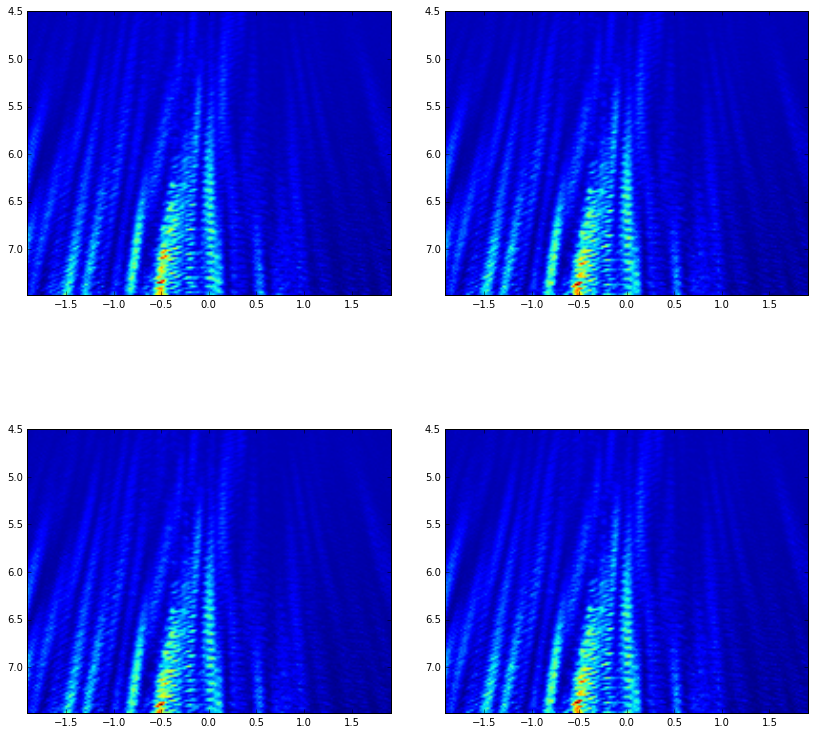

In [121]:
(nnr,nnc) = grnumaxis(len(ysteps))
gs=gridspec.GridSpec( nnr, nnc, wspace=0.15,hspace=0.15)

fig=plt.figure(figsize=(14,14))

vmax=np.max(imgDataVsY)
vmin=np.min(imgDataVsY)

ax2s=[]
for yi in range(len(ysteps)):
    (ii,jj) = grax_ij(yi,nnr,nnc)
    ax=fig.add_subplot(gs[ii, jj]) 
    ax2s.append( ax  )
    
    ax.imshow( imgDataVsY1[yi], extent =extent )
    

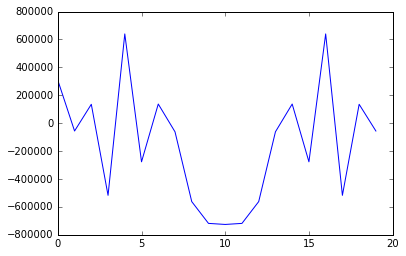

In [114]:
plt.plot( np.sum( ccfDataVsY,axis=(1,2)))